In [1]:
#Data generation imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyomo.environ as pyo

from utils import *

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate data
data = generate_ems_data(num_ems=10, start_date='2023-01-01', end_date='2023-12-31')

# Prepare the data to include 'Baseline', 'Congestion', and 'FlexPrice'

# Congestion on Mondays & Thursdays between 10 and 12 o'clock
data['Congestion'] = ((data['Time'].dt.weekday.isin([0, 3])) & 
                      (data['Time'].dt.hour.between(10, 12))).astype(int)

# Set flexibility price (e.g., $5/kWh) during congestion periods
data['FlexPrice'] = data['Congestion'] * 5 



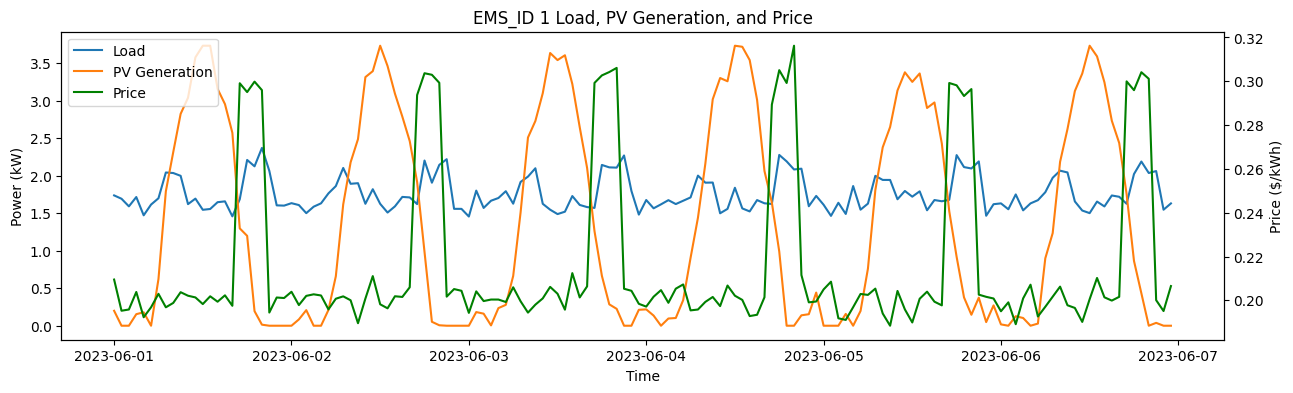

In [3]:
# Example: Plot Load and PV Generation for EMS_ID 1 over a week
ems_id = 1
start_date = '2023-06-01'
end_date = '2023-06-07'

mask = (data['EMS_ID'] == ems_id) & (data['Time'] >= start_date) & (data['Time'] < end_date)

plt.figure(figsize=(15, 4))

# Create the first y-axis
ax1 = plt.gca()
ax1.plot(data.loc[mask, 'Time'], data.loc[mask, 'Load'], label='Load')
ax1.plot(data.loc[mask, 'Time'], data.loc[mask, 'PV_Generation'], label='PV Generation')

# Create the second y-axis for Price
ax2 = ax1.twinx()
ax2.plot(data.loc[mask, 'Time'], data.loc[mask, 'Price'], color="green", label='Price')

# Set titles and labels
ax1.set_title(f'EMS_ID {ems_id} Load, PV Generation, and Price')
ax1.set_xlabel('Time')
ax1.set_ylabel('Power (kW)')
ax2.set_ylabel('Price ($/kWh)')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

In [4]:
# Assume 'data' is the DataFrame generated from the previous step
# It contains 'Time', 'EMS_ID', 'Load', 'PV_Generation', 'Price'

# Define BESS parameters
bess_params = {
    'capacity': 10,              # BESS capacity in kWh
    'soc_init': 0,               # Initial state of charge in kWh (50% SOC)
    'soc_min': 1,                # Minimum SOC in kWh
    'soc_max': 9,               # Maximum SOC in kWh
    'charge_efficiency': 0.98,   # Charging efficiency (95%)
    'discharge_efficiency': 0.98,# Discharging efficiency (95%)
    'charge_power_max': 5,       # Maximum charging power in kW
    'discharge_power_max': 5     # Maximum discharging power in kW
}

In [5]:
def optimize_ems_bess(data, ems_id, bess_params):
    """
    Optimize the BESS charging/discharging schedule for a single EMS unit.

    Parameters:
    - data: DataFrame containing 'Time', 'EMS_ID', 'Load', 'PV_Generation', 'Price'
    - ems_id: EMS_ID to optimize
    - bess_params: Dictionary containing BESS parameters

    Returns:
    - results_df: DataFrame with optimization results
    - total_cost: Total cost after optimization
    """
    # Filter data for the EMS unit
    ems_data = data[data['EMS_ID'] == ems_id].reset_index(drop=True)
    time_index = ems_data.index  # Use integer index for time steps

    # Parameters
    l_t = ems_data['Load'].values          # Load in kW - Increases grid demand (+)
    g_t = ems_data['PV_Generation'].values # PV generation in kW # Reduces grid demand (-)
    p_t = ems_data['Price'].values         # Price in $/kWh

    # BESS parameters
    capacity = bess_params['capacity']                  # kWh
    soc_init = bess_params['soc_init']                  # kWh
    soc_min = bess_params['soc_min']                    # kWh
    soc_max = bess_params['soc_max']                    # kWh
    eta_c = bess_params['charge_efficiency']            # Charging efficiency
    eta_d = bess_params['discharge_efficiency']         # Discharging efficiency
    s_max_ch = bess_params['charge_power_max']          # kW
    s_max_dis = bess_params['discharge_power_max']      # kW

    # Create model
    model = pyo.ConcreteModel()

    # Sets
    model.T = pyo.RangeSet(0, len(time_index) - 1)

    # Variables ---------------------------------------------------------------------------------------------------------
    model.s_ch = pyo.Var(model.T, within=pyo.NonNegativeReals)  # Charging power (kW) - Increases grid demand (+)
    model.s_dis = pyo.Var(model.T, within=pyo.NonNegativeReals) # Discharging power (kW) - Reduces grid demand (-)
    model.SOC = pyo.Var(model.T, within=pyo.NonNegativeReals)   # State of charge (kWh)
    model.z = pyo.Var(model.T, within=pyo.Binary)               # Binary variable for charge/discharge mode

    # Objective function: Minimize total cost - Price*x, where x = l - g - s_dis # s_ch --------------------------------
    def obj_rule(m):
        return sum(p_t[t] * (l_t[t] - g_t[t] - m.s_dis[t] + m.s_ch[t]) for t in m.T)
    model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

    # Constraints -------------------------------------------------------------------------------------------------------
    #SoC Update, SoC Limits, Power Limits, no simultanious charging

    # State of charge update: SoC + efficiency*energy
    def soc_update_rule(m, t):
        if t == 0:
            return m.SOC[t] == soc_init + eta_c * m.s_ch[t] - eta_d * m.s_dis[t]
        else:
            return m.SOC[t] == m.SOC[t - 1] + eta_c * m.s_ch[t] - eta_d * m.s_dis[t]
    model.soc_update = pyo.Constraint(model.T, rule=soc_update_rule)

    # State of charge limits: SoC within boundaries
    def soc_limits_rule(m, t):
        return pyo.inequality(soc_min, m.SOC[t], soc_max)
    model.soc_limits = pyo.Constraint(model.T, rule=soc_limits_rule)

    # Charging power limits: Only charge or discharge withon limits
    def charge_power_limit_rule(m, t):
        return m.s_ch[t] <= m.z[t] * s_max_ch
    model.charge_power_limit = pyo.Constraint(model.T, rule=charge_power_limit_rule)

    # Discharging power limits: Only charge or discharge withon limits
    def discharge_power_limit_rule(m, t):
        return m.s_dis[t] <= (1 - m.z[t]) * s_max_dis
    model.discharge_power_limit = pyo.Constraint(model.T, rule=discharge_power_limit_rule)
    
    
    # Solve the model -----------------------------------------------------------------------------------------------------
    # Use an available solver (e.g., GLPK, CBC)
    solver = pyo.SolverFactory('glpk')  # Replace 'glpk' with your solver if different

    result = solver.solve(model, tee=False)

    # Check solver status
    if (result.solver.status != pyo.SolverStatus.ok) or (result.solver.termination_condition != pyo.TerminationCondition.optimal):
        print(f"Warning: Solver did not find an optimal solution for EMS_ID {ems_id}")
        return None, None

    # Extract results
    s_ch = [pyo.value(model.s_ch[t]) for t in model.T]
    s_dis = [pyo.value(model.s_dis[t]) for t in model.T]
    SOC = [pyo.value(model.SOC[t]) for t in model.T]
    x_t = l_t - g_t + np.array(s_dis) - np.array(s_ch)

    # Compile results into DataFrame
    results_df = pd.DataFrame({
        'Time': ems_data['Time'],
        'EMS_ID': ems_id,
        'Load': l_t,
        'PV_Generation': g_t,
        'Price': p_t,
        's_ch': s_ch,
        's_dis': s_dis,
        'SOC': SOC,
        'x_t': x_t
    })

    total_cost = pyo.value(model.obj)

    return results_df, total_cost


In [6]:
# Optimize for all EMS units
ems_ids = data['EMS_ID'].unique()
all_results = []
total_system_cost = 0

for ems_id in ems_ids:
    results_df, total_cost = optimize_ems_bess(data, ems_id, bess_params)
    if results_df is not None:
        print(f"Total cost for EMS {ems_id}: ${total_cost:.2f}")
        all_results.append(results_df)
        total_system_cost += total_cost
    else:
        print(f"Optimization failed for EMS {ems_id}")

print(f"Total system cost: ${total_system_cost:.2f}")

# Combine all results into one DataFrame
all_results_df = pd.concat(all_results, ignore_index=True)

Total cost for EMS 1: $932.06
Total cost for EMS 2: $1196.81
Total cost for EMS 3: $1146.14
Total cost for EMS 4: $1486.88
Total cost for EMS 5: $1113.49
Total cost for EMS 6: $398.64
Total cost for EMS 7: $571.55
Total cost for EMS 8: $703.11
Total cost for EMS 9: $788.34
Total cost for EMS 10: $921.73
Total system cost: $9258.74


In [7]:
all_results_df

,Time,EMS_ID,Load,PV_Generation,Price,s_ch,s_dis,SOC,x_t
0,2023-01-01 00:00:00,1,1.329002,0.000000,0.202484,4.183673,0.000000,4.1,-2.854671
1,2023-01-01 01:00:00,1,1.500742,0.483639,0.199309,5.000000,0.000000,9.0,-3.982897
2,2023-01-01 02:00:00,1,1.204690,0.000000,0.203238,0.000000,3.163265,5.9,4.367955
3,2023-01-01 03:00:00,1,1.277795,0.000000,0.207615,0.000000,5.000000,1.0,6.277795
4,2023-01-01 04:00:00,1,1.504939,0.101534,0.198829,5.000000,0.000000,5.9,-3.596595
...,...,...,...,...,...,...,...,...,...
87365,2023-12-30 20:00:00,10,1.874527,0.000000,0.301464,0.000000,5.000000,1.0,6.874527
87366,2023-12-30 21:00:00,10,1.605987,0.142326,0.190598,5.000000,0.000000,5.9,-3.536339
87367,2023-12-30 22:00:00,10,1.258210,0.073423,0.192153,3.163265,0.000000,9.0,-1.978479
87368,2023-12-30 23:00:00,10,1.248561,0.000000,0.196816,0.000000,3.163265,5.9,4.411826


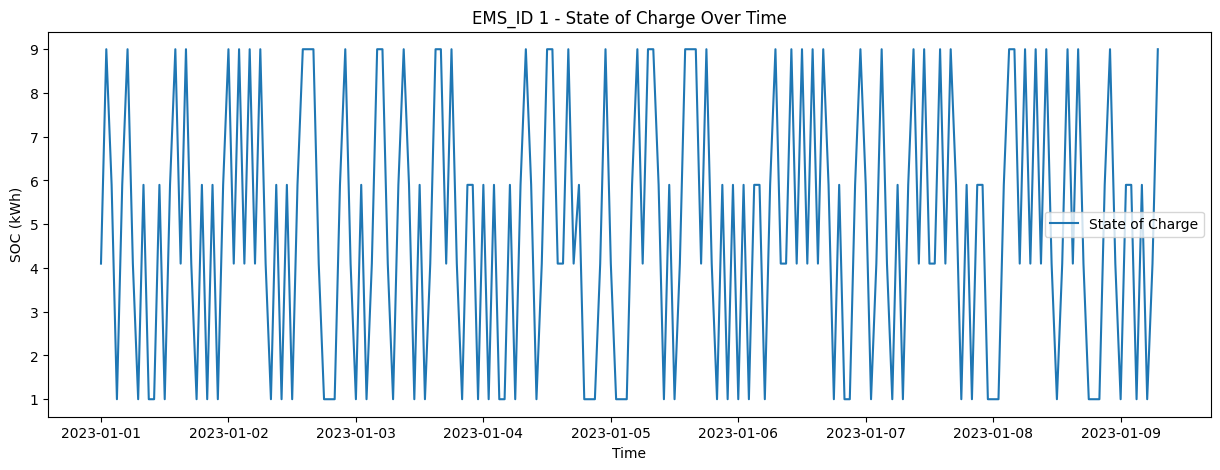

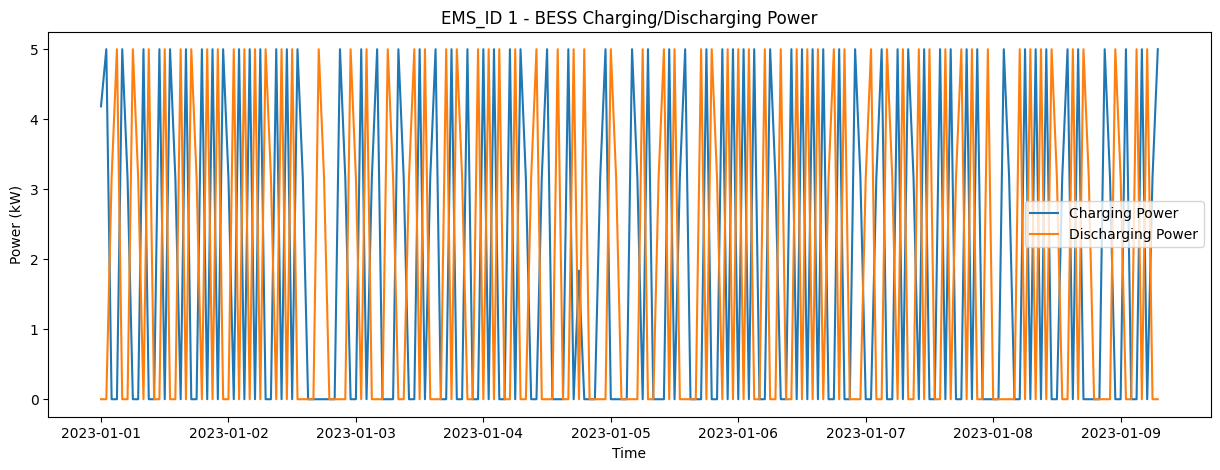

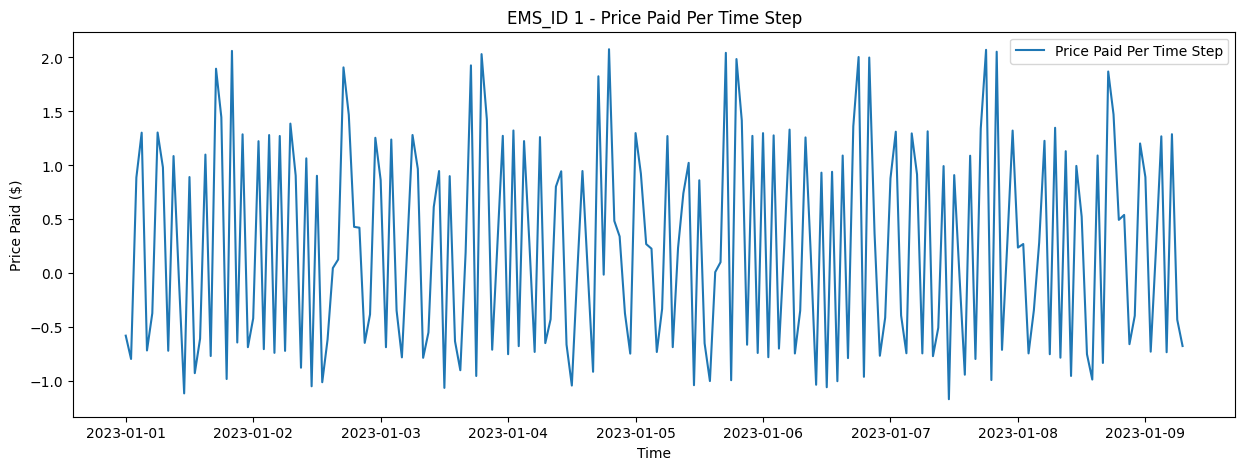

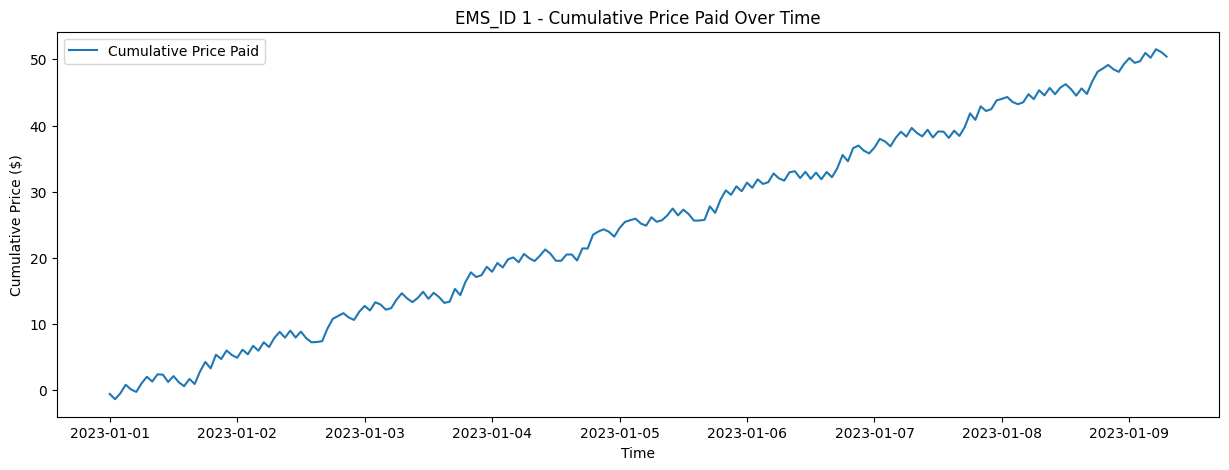

In [8]:
# Plotting SOC and BESS power for EMS_ID 1
ems_id = 1
ems_results = all_results_df[all_results_df['EMS_ID'] == ems_id][:200]  # Limit to the first 200 entries for clarity

# Plot SOC over time
plt.figure(figsize=(15, 5))
plt.plot(ems_results['Time'], ems_results['SOC'], label='State of Charge')
plt.title(f'EMS_ID {ems_id} - State of Charge Over Time')
plt.xlabel('Time')
plt.ylabel('SOC (kWh)')
plt.legend()
plt.show()

# Plot Charging and Discharging Power
plt.figure(figsize=(15, 5))
plt.plot(ems_results['Time'], ems_results['s_ch'], label='Charging Power')
plt.plot(ems_results['Time'], ems_results['s_dis'], label='Discharging Power')
plt.title(f'EMS_ID {ems_id} - BESS Charging/Discharging Power')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

# Calculate the price paid per time step
ems_results['Price_Paid'] = ems_results['Price'] * ems_results['x_t']

# Plot Price Paid per Time Step
plt.figure(figsize=(15, 5))
plt.plot(ems_results['Time'], ems_results['Price_Paid'], label='Price Paid Per Time Step')
plt.title(f'EMS_ID {ems_id} - Price Paid Per Time Step')
plt.xlabel('Time')
plt.ylabel('Price Paid ($)')
plt.legend()
plt.show()

# Calculate cumulative price paid
ems_results['Cumulative_Price'] = ems_results['Price_Paid'].cumsum()

# Plot Cumulative Price Paid
plt.figure(figsize=(15, 5))
plt.plot(ems_results['Time'], ems_results['Cumulative_Price'], label='Cumulative Price Paid')
plt.title(f'EMS_ID {ems_id} - Cumulative Price Paid Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Price ($)')
plt.legend()
plt.show()
